# Description

# Import Python

In [1]:
verbose = False
debugging = False
ipts_group = 'IPTS_17099'

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

import config_handler
import file_handler
import utilities
import gui_widgets
import time_utility

In [2]:
%gui qt

# Import Images (Data and OB)

## Data

In [3]:
data_folder = config_handler.load_config(key='data_folder',
                                        default_value = '/Volumes/my_book_thunderbolt_duo/IPTS/IPTS_17099/',
                                        group=ipts_group)
new_data_folder = gui_widgets.gui_dname(dir=data_folder,
                                   message='Select the Data Folder ...')
if new_data_folder:
    config_handler.save_config(key='data_folder', value=new_data_folder, group=ipts_group)
    list_of_data_files = glob.glob(new_data_folder + '/*.tiff')

In [4]:
w = widgets.IntProgress()
w.max = len(list_of_data_files)
display(w)

data_array = []
for _index, _file in enumerate(list_of_data_files):
    _image = file_handler.load_data(_file)
    data_array.append(_image)
    w.value = _index + 1

## OB

In [5]:
ob_folder = config_handler.load_config(key='ob_folder',
                                        default_value = '/Volumes/my_book_thunderbolt_duo/IPTS/IPTS_17099/',
                                        group=ipts_group)
list_ob_files = gui_widgets.gui_fname(dir=ob_folder,
                                       message='Select the OB Files...',
                                         ext='tiff')
if list_ob_files:
    config_handler.save_config(key='ob_folder', value=os.path.dirname(list_ob_files[0]), group=ipts_group)


In [6]:
w = widgets.IntProgress()
w.max = len(list_ob_files)
display(w)

ob_array = []
for _index, _file in enumerate(list_ob_files):
    _image = file_handler.load_data(_file)
    ob_array.append(_image)
    w.value = _index + 1
    
mean_ob = np.mean(ob_array, axis=0)

## Data/OB

### Checking that Data and OB Acquisition Time are Equal

In [7]:
# select 2 random file from the list of data and ob
nbr_data = len(list_of_data_files)
random_data_index = np.random.randint(0, nbr_data)

nbr_ob = len(list_ob_files)
random_ob_index = np.random.randint(0, nbr_ob)

# retrieving collection_time for both files
data_exposure_time = time_utility.retrieve_exposure_time(list_of_data_files[random_data_index])
ob_exposure_time = time_utility.retrieve_exposure_time(list_ob_files[random_ob_index])

assert data_exposure_time == ob_exposure_time

### Normalization

In [8]:
mean_ob[mean_ob == 0] = np.NAN
normalized_data = np.divide(data_array, mean_ob)
normalized_data[normalized_data == np.NAN] = 0

578

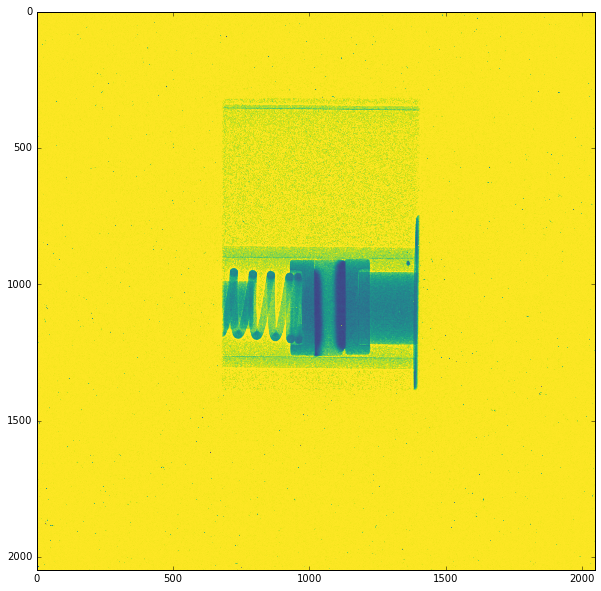

In [9]:
def plot_images(image_index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(normalized_data[image_index], cmap='viridis', vmin=0, vmax=1)

    
    return image_index
    
preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0, 
                                                max=len(normalized_data)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index'))

# Crop Data 

[980, 880, 200, 400]

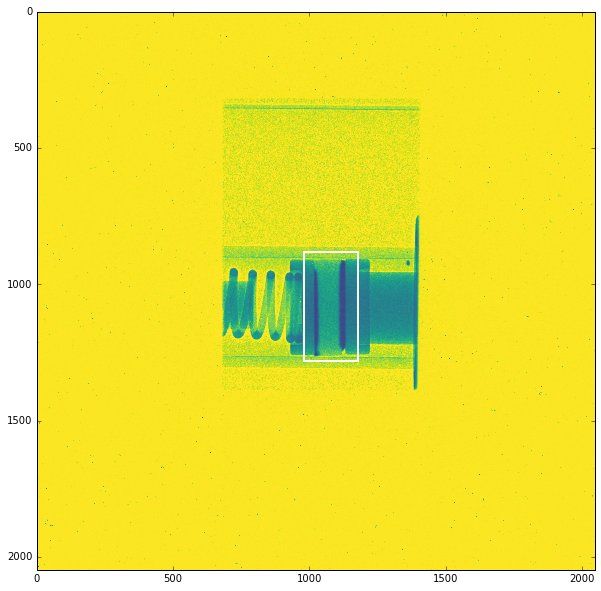

In [10]:
[height, width] = np.shape(normalized_data[0])

def plot_images(image_index, x_left, y_top, width, height):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(normalized_data[image_index],
                 cmap='viridis',
                 vmin=0, vmax=1)
    
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    return [x_left, y_top, width, height]
    
preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0,
                                                 max=len(normalized_data),
                                                 value=0,
                                                 description='File Index'),
                  x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=980,
                                            description='X Left'),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=880,
                                           step=1,
                                           description='Y Top'),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=200,
                                           description="Width"),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=400,
                                            description='Height'))

In [11]:
[x_left, y_top, width, height] = preview.widget.result
cropped_data = [_data[y_top:y_top+height, x_left:x_left+width] for _data in normalized_data]

648

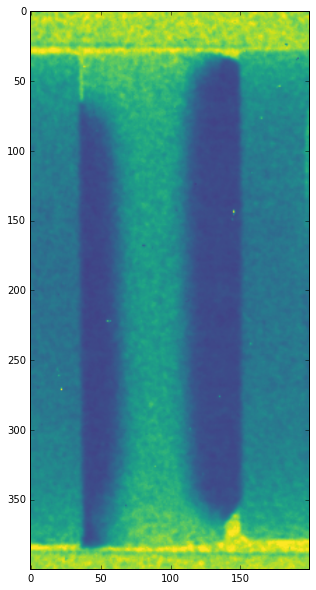

In [12]:
def plot_images(image_index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(cropped_data[image_index], cmap='viridis', vmin=0, vmax=1)

    
    return image_index
    
preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0, 
                                                max=len(normalized_data)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index'))

# Export Cropped/Normalized Data

In [13]:
output_folder = config_handler.load_config(key='output_folder', group=ipts_group)
new_output_folder = gui_widgets.gui_dname(dir=output_folder,
                                   message='Select the Output Folder ...')
if new_output_folder:
    config_handler.save_config(key='output_folder', value=new_output_folder, group=ipts_group)
    
    short_list_of_data_files = [os.path.basename(_file) for _file in list_of_data_files]

    w = widgets.IntProgress()
    w.max = len(short_list_of_data_files)
    display(w)
    
    for _index, _short_file in enumerate(short_list_of_data_files):
        _full_file_name = os.path.join(new_output_folder, _short_file)
        _data = cropped_data[_index]
        file_handler.make_tiff(data=_data, filename=_full_file_name)
        w.value = _index+1
    